## This notebook records steps for extrapolation May Creek temperatures to USGS gage temperatures to fill the USGS gap during winter 2018/2019

In [18]:

# Imports

import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from scipy import stats
# set up
pd.plotting.register_matplotlib_converters()
plt.style.use('ggplot')

# data folder
format_data = r'C:\Users\tamaral\Documents\GIP-2020\Kennicott\PROJECT\Kennicott-Glacier-Sharing\DATA'

#%%
# --- Load Data
meta = pd.read_pickle(os.path.join(format_data,'temperature_meta.pickle'))
dd = pd.read_pickle(os.path.join(format_data,'daily_temperature_data.pickle'))


### First, I've defined several functions for use in the subsequent analysis. 

In [13]:
def temp_scat(x,y,title,labels,legend=False):
    fig,ax = plt.subplots(figsize=(9,9))
    ax.set_title(title)
    # plot data
    ax.scatter(x,y,s=8,color='steelblue')
    # plot 1 to 1 line
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k-', lw=3,label='1 to 1 line')
    # put r^2 and regression line on plot
    mask = ~np.isnan(x) & ~np.isnan(y)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x[mask],y[mask])
    r2 = r_value**2
    xo = np.linspace(x.min(),x.max(),)
    Yhat = (slope*xo) + intercept # regression y coords
    ax.plot(xo,Yhat,'--',linewidth=3,color='darkorchid',label='OLS line')
    # annotate with r2 and regression equation
    ax.annotate('$r^2$ = {:.2f}'.format(r2),(-40,-25),fontsize=14)
    ax.annotate('y = {0:.2f}(x) + {1:.2f}'.format(slope,intercept),(5,0),fontsize=12)
    # labels
    ax.axis('square')
    ax.set_xlabel(label[0])
    ax.set_ylabel(label[1])
    if legend:
        ax.legend(loc='upper left')
    # display
    fig.tight_layout()
    plt.show()
    
def gap_ix(df):
    """ Fill in a second index to use in extracting data"""
    seasons = {'summer': [6,7,8,9], 
               'winter_gap': [1,2,3,4,5,10,11,12]} # this can be adjusted based on distribution of values
    months = {num:sea for sea in seasons.keys()
                            for num in seasons[sea]}
    # name winter according to year which it starts
    sea = pd.Series(df.index.month).map(months)
    # put back into dataframe
    seaidx = pd.Index(sea,name='GAP')
    df = df.set_index(seaidx,append=True)
    
    return df


### To arrive at a linear regression used to extrapolate values to the USGS station, first we must confirm several statistical assumptions
### 1. Normally distributed data
### 2. Homogeneity of variance
### 3. Independent errors
### 4. Linear relationship between independent and dependant variables. 

In [19]:
# --- Subset data from other years' winters

# get date range for the usgs gap during winter 2018/2019
start = pd.Timestamp('2018-01-01 00:00:00-0800',tz='US/Alaska')
end = pd.Timestamp('2019-08-01 00:00:00-0800',tz='US/Alaska')
idx=pd.IndexSlice
# grab the usgs TAVG series
period = dd.loc[slice(start,end),idx['usgs','TAVG']] # isolate year with the winter gap
gaps = period.loc[pd.isna(period)].index
print('Missing data are from {} through {}'.format(gaps[0],gaps[-1]))


Missing data are from 2018-10-10 00:00:00-08:00 through 2019-05-08 00:00:00-08:00


### extract data from october - may as " training data" for OLS

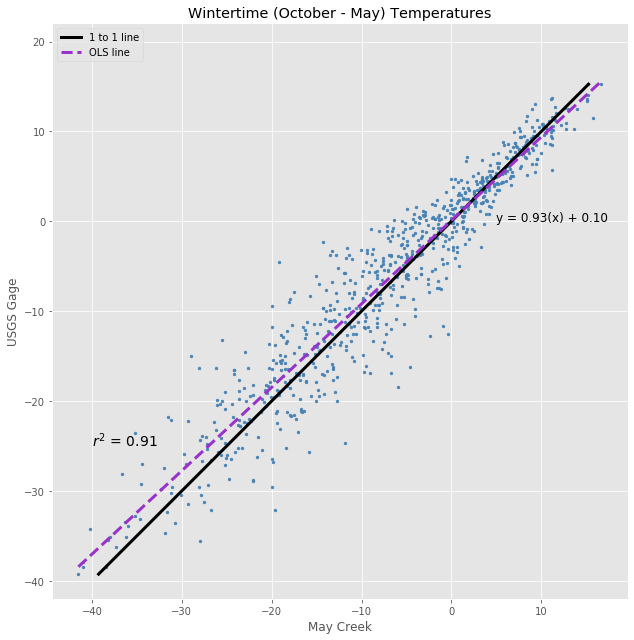

In [20]:
# --- Extract and plot data relationship between stations
dd = gap_ix(dd)
# subset winter data for usgs, may sites for TAVG variable
idx = pd.IndexSlice
train = dd.loc[idx[:,'winter_gap'],idx[['usgs','may'],'TAVG']].copy()
# drop gap index
train = train.reset_index(level=1,drop=True) # remove gap index
# drop columns level
train.columns = train.columns.droplevel(1) # remove TAVG labels 

x = train['may']
y = train['usgs']
title = ('Wintertime (October - May) Temperatures')
label = ['May Creek','USGS Gage']

temp_scat(x,y,title,label,legend=True)



### This confirms the assumption that there is a linear relationship between the temperature records
### Next we can plot a histogram (to check normalcy) and the residuals

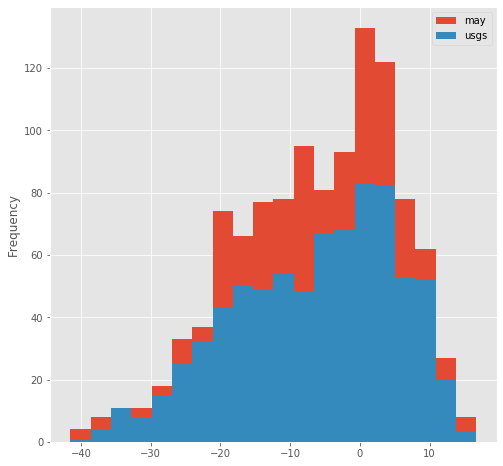

In [21]:
# 1. Histogram 
train.plot(kind='hist',bins=20,figsize=(8,8))
# ... normal enough! 
plt.show()

### This histogram confirms that our data are (roughly) normal. I included the month of June in these data sets since the distribution was left skewed (cooler temperatures) more noticeably without June temperatures included

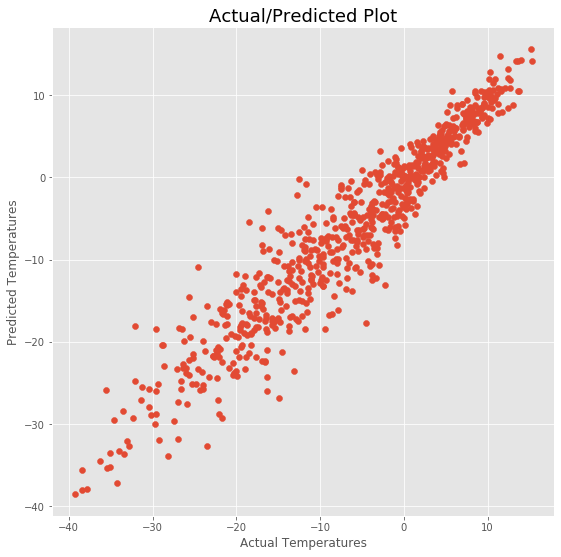

In [22]:
# 2. Residuals plot
x = train['may']
y = train['usgs']
mask = ~np.isnan(x) & ~np.isnan(y)
slope, intercept, r_value, p_value, std_err = stats.linregress(x[mask],y[mask])
Yhat = (slope*x) + intercept # regression-precicted y coords
res = y - Yhat #  actual - predicted

# --- Actual/Predicted Plot
fig,ax = plt.subplots(figsize=(9,9))
ax.set_title('Actual/Predicted Plot',fontsize=18)
ax.scatter(y,Yhat)
ax.set_xlabel('Actual Temperatures')
ax.set_ylabel('Predicted Temperatures')
plt.show()


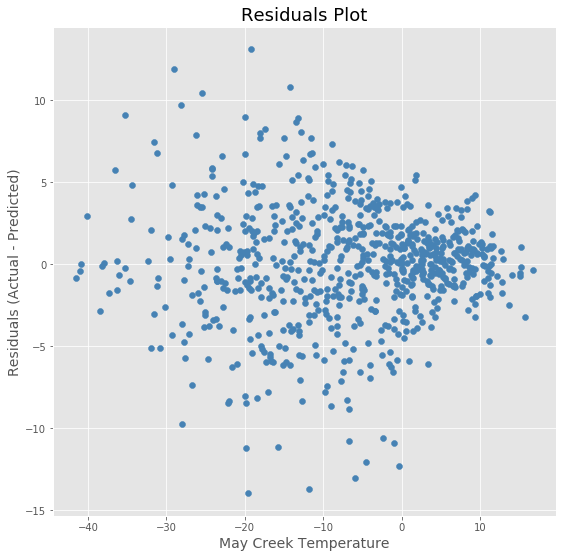

In [23]:
# --- Residuals vs x
fig,ax = plt.subplots(figsize=(9,9))
ax.set_title('Residuals Plot',fontsize=18)
ax.scatter(x,res,color='steelblue')
ax.set_ylabel('Residuals (Actual - Predicted)',fontsize=14)
ax.set_xlabel('May Creek Temperature',fontsize=14)
plt.show()

### The residual plot above lets us confirm the remaining two assumptions: variance and indepenent errors. Though not perfect, we have roughly random errors there that only minimally scale with May Creek Temperature. We also have okay variance across the temperature range, that appears slightly skewed to increase as temperatures decrease, but not in a way that makes me consider a more complex statistical model.  

### Lastly, missing data from 2018/2019 winter at the USGS gage site is extrapolated using regressed May Creek daily TAVG values. 

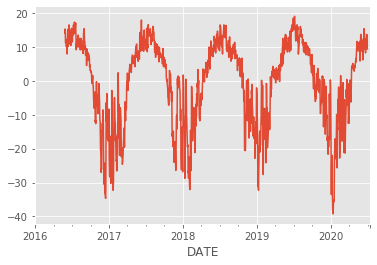

In [24]:
# --- Complete usgs record with adjusted may temps
idx = pd.IndexSlice
dtvg = dd.loc[:,idx[['usgs','gates','buri'],'TAVG']].copy() # new df
dtvg = dtvg.reset_index(level=1,drop=True) # remove gap index
dtvg.columns = dtvg.columns.droplevel(1) # remove tavg index
# direct assignment fill values
may_vals = train.loc[idx[gaps[0]:gaps[-1]],'may'].copy()
fill = (may_vals *  slope) + intercept # slope, intercept defined in cell above
# swap in values
dtvg.loc[idx[gaps[0]:gaps[-1]],'usgs'] = fill # direct fill

# view complete record
dtvg.loc[:,'usgs'].plot()

# save new record 
dtvg.to_pickle(os.path.join(format_data,'daily_tavg.pickle'))
dtvg.to_csv(os.path.join(format_data,'daily_tavg.csv'))